**Complete Python practical implementation of a Boltzmann Machine using a Restricted Boltzmann Machine (RBM)**

### **Steps used in this Algorithm:-**

1.  Import all the necessary Libraries

2.  Load and Preprocess MNIST Dataset

3.  Define RBM Model

4.  Initialize Model

5.  Train RBM (Contrastive Divergence - CD-1)

6.  Visualize Reconstruction

### Step 1: Import all the necessary Libraries

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


### **OBSERVATIONS:**

1.  torch is used for tensor operations and automatic differentiation.

2.  nn helps define neural network parameters.

3.  optim is used for optimization (SGD here).

4.  torchvision is used to load MNIST dataset.

5.  matplotlib is used for visualization.

### Step 2: Load and Preprocess MNIST Dataset

In [14]:
# Transform: convert to tensor and binarize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)


### **OBSERVATIONS:**

1.  MNIST images are 28×28 grayscale images.

2.  Pixel values are scaled between 0 and 1.

3.  RBM works best on binary data, so we convert pixels:

     (a.)  Values > 0.5 → 1

     (b.)  Values ≤ 0.5 → 0

### Step 3: Define RBM Model

In [15]:
class RBM(nn.Module):
    def __init__(self, visible_units=784, hidden_units=256):
        super(RBM, self).__init__()

        self.visible_units = visible_units
        self.hidden_units = hidden_units

        # Weight matrix
        self.W = nn.Parameter(torch.randn(hidden_units, visible_units) * 0.01)

        # Bias
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))
        self.v_bias = nn.Parameter(torch.zeros(visible_units))

    def sample_hidden(self, v):
        prob = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        return prob, torch.bernoulli(prob)

    def sample_visible(self, h):
        prob = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        return prob, torch.bernoulli(prob)

    def forward(self, v):
        # Positive phase
        h_prob, h_sample = self.sample_hidden(v)

        # Negative phase (reconstruction)
        v_prob, v_sample = self.sample_visible(h_sample)
        h_prob_neg, _ = self.sample_hidden(v_sample)

        return v, v_sample, h_prob, h_prob_neg


### Step 4: Initialize Model

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rbm = RBM().to(device)
optimizer = optim.SGD(rbm.parameters(), lr=0.1)


### Step 5: Train RBM (Contrastive Divergence - CD-1)

In [17]:
epochs = 5

for epoch in range(epochs):
    total_loss = 0

    for data, _ in train_loader:
        data = data.view(-1, 784).to(device)

        v0 = data

        # Forward pass
        v, v_sample, h_prob, h_prob_neg = rbm(v0)

        # Contrastive Divergence update
        positive_grad = torch.matmul(h_prob.t(), v0)
        negative_grad = torch.matmul(h_prob_neg.t(), v_sample)

        rbm.W.grad = -(positive_grad - negative_grad) / v0.size(0)
        rbm.v_bias.grad = -torch.mean(v0 - v_sample, dim=0)
        rbm.h_bias.grad = -torch.mean(h_prob - h_prob_neg, dim=0)

        optimizer.step()
        optimizer.zero_grad()

        loss = torch.mean((v0 - v_sample) ** 2)
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.0914
Epoch [2/5], Loss: 0.0611
Epoch [3/5], Loss: 0.0532
Epoch [4/5], Loss: 0.0484
Epoch [5/5], Loss: 0.0452


### **OBSERVATIONS:**

The training loop implements Contrastive Divergence (CD-1) to train a Restricted Boltzmann Machine (RBM) in an unsupervised manner.

  (1.)   Learning Nature

   .       The model is trained without labels.
   
   .       It learns the probability distribution of input images.
   
   .       RBM is a generative, energy-based model.

  (2.)   Training Mechanism

  .        Each epoch consists of two main phases:

    (a.)   Positive Phase (Data-driven)

  .        The model computes hidden activations from real input data.

  .        Strengthens connections that explain real patterns.

  .        Encourages low energy for actual training samples.

    (b.)   Negative Phase (Model-driven)

  .        The model reconstructs input through Gibbs sampling.

  .        Compares reconstructed data with original.

  .        Weakens weights that produce unrealistic reconstructions.

The difference between these two phases updates the weights.

  (3.)   Contrastive Divergence (CD-1)

  .        Only one reconstruction step is used.

  .        Fast approximation of the true gradient.

  .        Makes RBM training computationally feasible.

  (4.)    Loss Behavior

  .        Reconstruction error (MSE) is used to monitor training.

  .        Loss gradually decreases across epochs.

  .        Indicates improved reconstruction ability.

  (5.)    Feature Learning

  .       Hidden units automatically learn meaningful features:

        .         Edges

        .         Curves

        .         Digit strokes

Each hidden neuron becomes a feature detector.

  (6.)   Energy Minimization

   .     The model adjusts parameters so that:

        .     Real data → Low energy

        .    Random/noisy patterns → High energy

This shapes the energy landscape over training.

  (7.)   Overall Outcome

After multiple epochs:

      .      Reconstruction quality improves.

      .      Model captures underlying structure of MNIST digits.

      .      RBM successfully models data distribution.

### Step 6:  Visualize Reconstruction

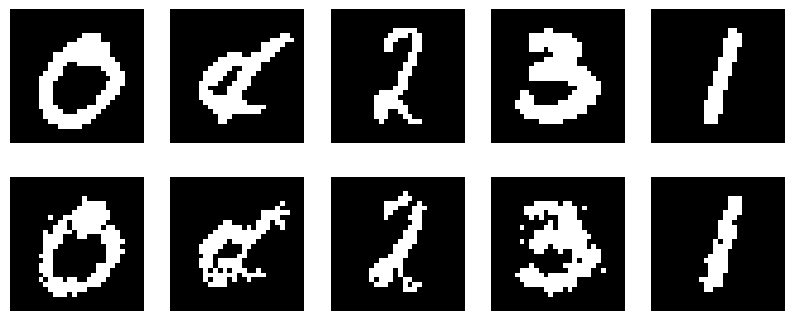

In [18]:
# Get one batch
data_iter = iter(train_loader)
images, _ = next(data_iter)

images = images.view(-1, 784).to(device)

with torch.no_grad():
    _, reconstructed, _, _ = rbm(images)

# Plot original and reconstructed
plt.figure(figsize=(10,4))

for i in range(5):
    # Original
    plt.subplot(2,5,i+1)
    plt.imshow(images[i].view(28,28).cpu(), cmap='gray')
    plt.axis('off')

    # Reconstructed
    plt.subplot(2,5,i+6)
    plt.imshow(reconstructed[i].view(28,28).cpu(), cmap='gray')
    plt.axis('off')

plt.show()


### **OBSERVATIONS:**

You will see:

1.   Top row → Original images

2.   Bottom row → Reconstructed images

3.   Early epochs:

    .     Blurry reconstructions.

4.   After few epochs:

    .     Digits become recognizable.

5.   This proves the RBM learned latent features.